## PREDICT  WHICH  INDIVIDUALS ARE MOST LIKELY TO HAVE OR USE A BANK ACCOUNT



### FINANCIAL INCLUSION IN AFRICA


#### Zindi Knowledge Competition

## Business Objective

The objective of this analysis is to create a machine learning model to predict which individuals are most likely to have or use a bank account.

### DATA COLUMN DESCRIPTION

* country: Country interviewee is in.
* year: Year survey was done in.
* uniqueid: Unique identifier for each interviewee
* location_type: Type of location: Rural, Urban
* cellphone_access: If interviewee has access to a cellphone: Yes, No
* household_size: Number of people living in one house
* age_of_respondent: The age of the interviewee
* gender_of_respondent: Gender of interviewee: Male, Female
* relationship_with_head: The interviewees relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know
* marital_status: The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Dont know
* education_level: Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA
* job_type: Type of job interviewee has: Farming and Fishing, Self employed, Formally employed Government, Formally employed Private, Informally employed, Remittance Dependent, Government Dependent, Other Income, No Income, Dont Know/Refuse to answer


In [79]:
 pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, r2_score
from tqdm import tqdm_notebook, tqdm
from scipy import stats
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import model_selection
import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from scipy.optimize import minimize
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [81]:
# read in dataset

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## UNDERSTANDING THE DATA ( Descriptive Statistics)

In [82]:
# check the shape of the data
print(f'The shape of the train data is {train.shape}')
print(f'The shape of the test data is {test.shape}')

# Each row represents a person, each column contains customer’s attributes described on the column data.
train.head()


The shape of the train data is (23524, 13)
The shape of the test data is (10086, 12)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [83]:
#Each row represents a person, each column contains customer’s attributes described on the column test data.

test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [84]:
# check the info

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [85]:
# check for missing values

print(f'The number of missing values  {train.isna().sum()}')
print('\n')
print(f'The percentage of missing values  {train.isna().mean() * 100}')

The number of missing values  country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


The percentage of missing values  country                   0.0
year                      0.0
uniqueid                  0.0
bank_account              0.0
location_type             0.0
cellphone_access          0.0
household_size            0.0
age_of_respondent         0.0
gender_of_respondent      0.0
relationship_with_head    0.0
marital_status            0.0
education_level           0.0
job_type                  0.0
dtype: float64


In [86]:
# checking the parameters of the first 3 rows

train.head(3)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed


In [87]:
# understanding the location_type features

train.country.value_counts()

Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64

In [88]:
# understanding the location_type features

train.location_type.value_counts()


Rural    14343
Urban     9181
Name: location_type, dtype: int64

In [89]:
# understanding the household_size features

train['household_size'].unique()

array([ 3,  5,  8,  7,  1,  6,  4, 10,  2, 11,  9, 12, 16, 15, 13, 14, 21,
       18, 17, 20], dtype=int64)

In [90]:
# understanding the age_of_respondent features

train['age_of_respondent'].unique()

array([ 24,  70,  26,  34,  32,  42,  54,  76,  40,  69,  64,  31,  38,
        47,  27,  48,  25,  21,  18,  22,  58,  55,  62,  29,  35,  45,
        67,  19,  80,  66,  50,  33,  28,  51,  16,  17,  30,  37,  59,
        65,  46,  56,  52,  23,  43,  49,  44,  72,  53,  63,  39,  81,
        78,  36,  20,  60,  95,  71,  57,  85,  68,  41,  61,  75,  86,
        73,  93,  74,  88,  90,  77,  84,  82,  89,  79,  83,  94,  87,
        92,  91,  98,  97,  96,  99, 100], dtype=int64)

In [91]:
# understanding the gender_of_respondent features

train['gender_of_respondent'].value_counts()

Female    13877
Male       9647
Name: gender_of_respondent, dtype: int64

In [92]:
# understanding the relationship_with_head features

train['relationship_with_head'].value_counts()

Head of Household      12831
Spouse                  6520
Child                   2229
Parent                  1086
Other relative           668
Other non-relatives      190
Name: relationship_with_head, dtype: int64

In [93]:
# understanding the marital_status features

train['marital_status'].value_counts()

Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: marital_status, dtype: int64

In [94]:
# understanding the education_level features

train['education_level'].value_counts()

Primary education                  12791
No formal education                 4515
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Other/Dont know/RTA                   35
Name: education_level, dtype: int64

In [95]:
# understanding the education_level features

train['year'].value_counts()

2016    8735
2018    8169
2017    6620
Name: year, dtype: int64

In [96]:
# understanding the target variable features

train['bank_account'].value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

In [97]:
train.head(2)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent


In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [99]:
# Now lets describe our dataset while transposing

train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,23524.0,2016.975939,0.847371,2016.0,2016.0,2017.0,2018.0,2018.0
household_size,23524.0,3.797483,2.227613,1.0,2.0,3.0,5.0,21.0
age_of_respondent,23524.0,38.805220,16.520569,16.0,26.0,35.0,49.0,100.0


### $\color{red}{\text{SPLITTING INTO TRAIN AND TEST DATA }}$

In [100]:
train.head(10)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed
5,Kenya,2018,uniqueid_6,No,Rural,No,7,26,Female,Spouse,Married/Living together,Primary education,Informally employed
6,Kenya,2018,uniqueid_7,No,Rural,Yes,7,32,Female,Spouse,Married/Living together,Primary education,Self employed
7,Kenya,2018,uniqueid_8,No,Rural,Yes,1,42,Female,Head of Household,Married/Living together,Tertiary education,Formally employed Government
8,Kenya,2018,uniqueid_9,Yes,Rural,Yes,3,54,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing
9,Kenya,2018,uniqueid_10,No,Urban,Yes,3,76,Female,Head of Household,Divorced/Seperated,No formal education,Remittance Dependent


In [101]:
#train shape

train.shape

(23524, 13)

In [102]:
test.shape

(10086, 12)

### UNIVARIATE EXPLORATION

In [103]:
# let's check the proportion of customers that has churned,

#Target variable

train['bank_account'].describe()

count     23524
unique        2
top          No
freq      20212
Name: bank_account, dtype: object

Text(0.5, 0, 'Bank Account')

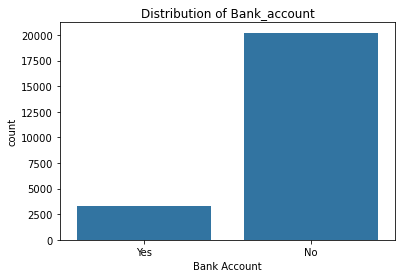

In [104]:
# let's plot the countplot for target variable

base_color = sns.color_palette()[0]
sns.countplot(data = train, x = 'bank_account', color = base_color);
plt.title("Distribution of Bank_account")
plt.xlabel('Bank Account')

## NUMERICAL FEATURES RELATIONSHIPS

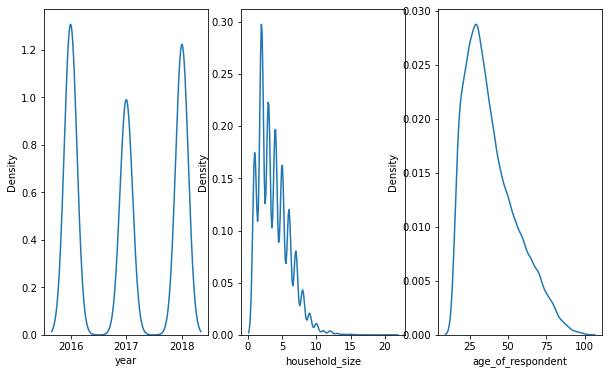

In [105]:
col = ['year', 'household_size','age_of_respondent'] #numerical features
fig = plt.figure(figsize=(10,6))
a = 1
b = 3
c = 1
for  i in col:
        plt.subplot(a,b,c)
        sns.kdeplot(x=train[i],data=train, palette ="CMRmap") #plots kde for numerical variable
        c = c + 1

* Most of the respondents survey were collected in the year 2016, then 2018 and 2017 respectively.
* Majority of the respondent has a toal household size  of 3 to 4.
* The average age of respondents are between 35 to 50.

In [106]:
#train columns

train.columns.values

array(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'], dtype=object)

## CATEGORICAL VARIABLES RELATIONSHIP

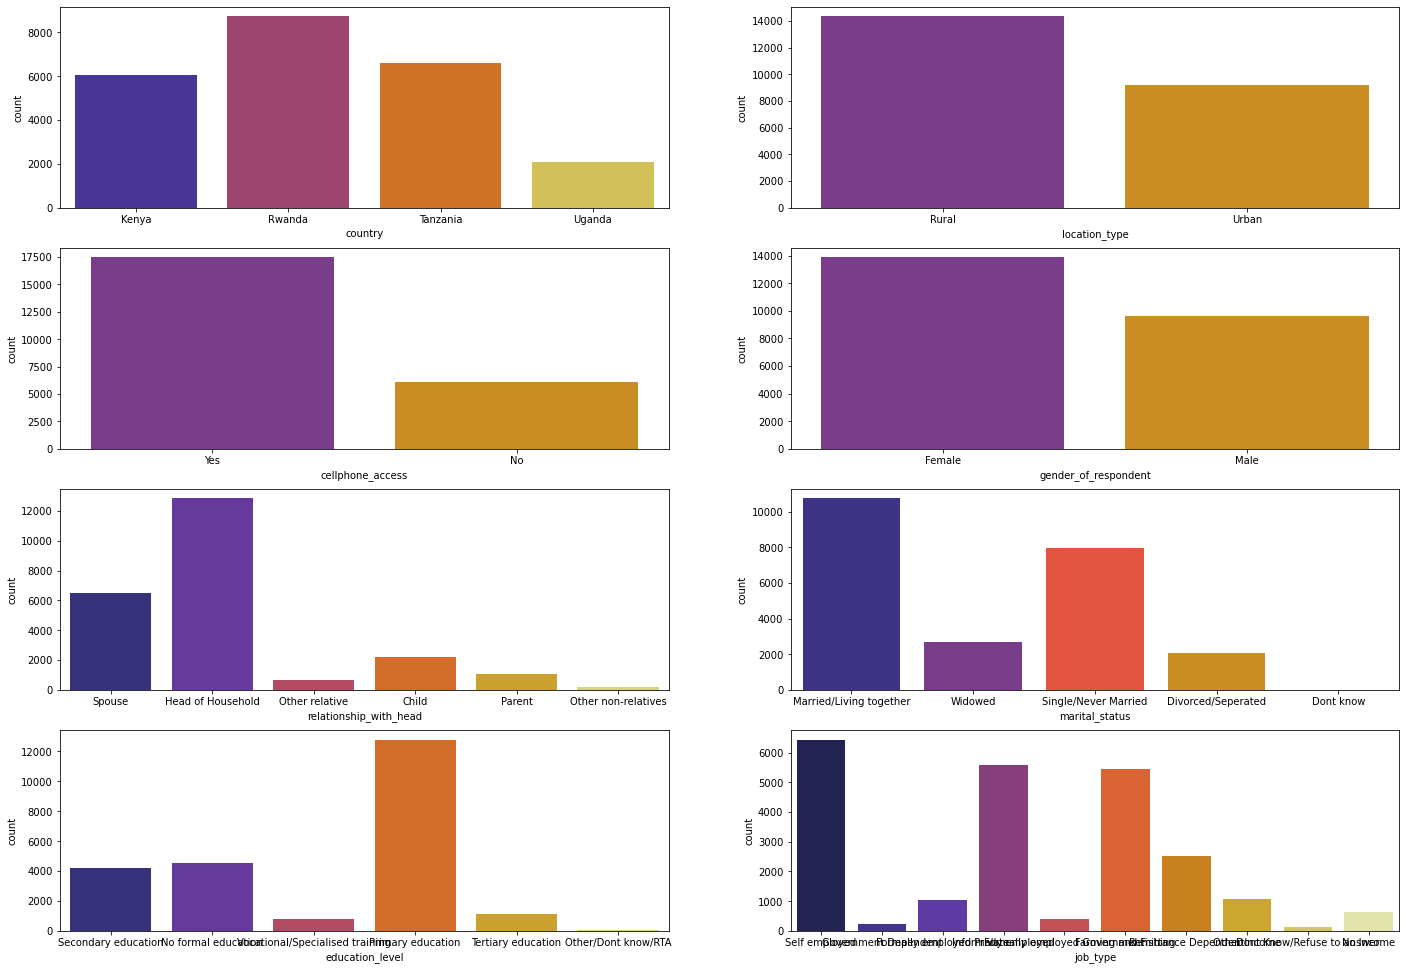

In [107]:
cat_col = ['country','location_type', 'cellphone_access','gender_of_respondent',
            'relationship_with_head','marital_status','education_level','job_type']
fig = plt.figure(figsize=(24,17))
a = 4 #number of rows
b = 2 #number of columns
c = 1 #counter
for  i in cat_col:
        plt.subplot(a,b,c)
        sns.countplot(x= train[i], data=train, palette="CMRmap")
        c = c + 1

### From the visualisations above it can be inferred that;

    
* Most of the respondent are from Rwanda.

* Majority of the respondent are from the rural area. 

* Most of the respondent has access to Cellphone 

* The female folk respond more to the survey and most of them are the head of their household

* Majority of the respondents are married followed by the singles respectively.

* Majority of the respondents had only Primary education followed by those with no formal education and secondary education respectively.

### MULTIVARIATE EXPLORATION

In [108]:
# converting target variable to binary code

bankaccount= {'Yes': 1, 'No': 0}
train['bank_account1'] = train['bank_account'].map(bankaccount)

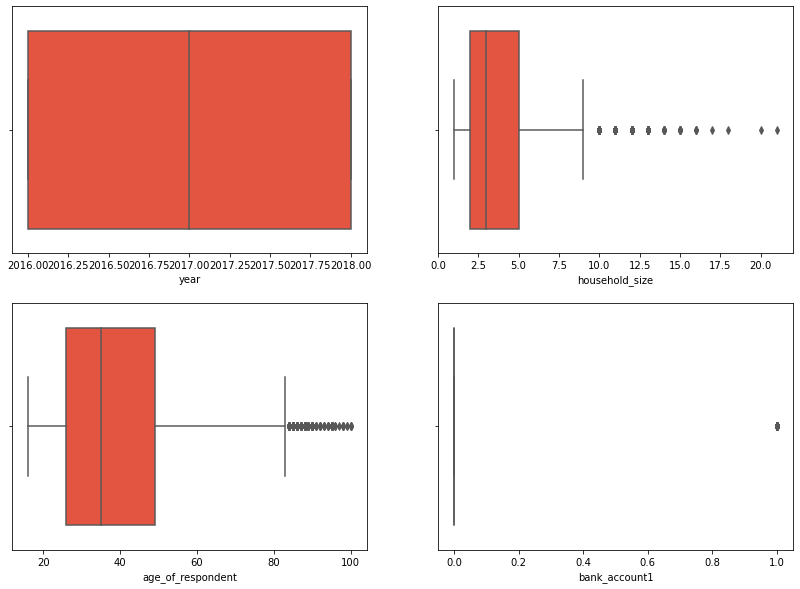

In [109]:
col1 = ['year', 'household_size','age_of_respondent','bank_account1'] #numerical features
fig = plt.figure(figsize=(14,10))
a = 2
b = 2
c = 1
for  i in col1:
        plt.subplot(a,b,c)
        sns.boxplot(x=train[i],data=train, hue='bank_account1', palette ="CMRmap") #plots kde for numerical variable
        c = c + 1

* we could see above that Total Claim amount,Premium Auto Per month and Customer Worth has alot of outliers,this might signal some chances of multicollinearity between the parameters.

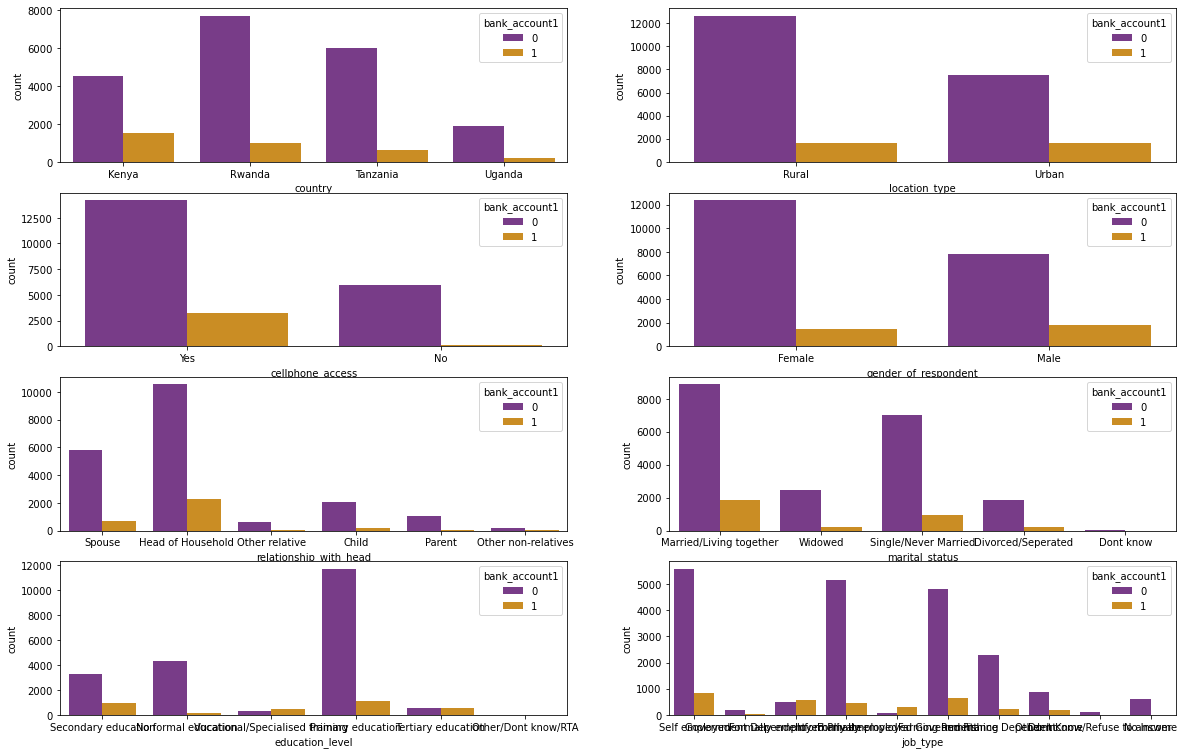

In [110]:
cat_col = ['country','location_type', 'cellphone_access','gender_of_respondent',
            'relationship_with_head','marital_status','education_level','job_type']
fig = plt.figure(figsize=(20,13))
a = 4 #number of rows
b = 2 #number of columns
c = 1 #counter
for  i in cat_col:
        plt.subplot(a,b,c)
        sns.countplot(x= train[i], data=train, hue='bank_account1', palette="CMRmap")
        c = c + 1

* it is safe to assume that majority og the respondent don't have a bank account

### MULTICOLINEARITY IN NUMERICAL VARIABLES 

With a multicolinearity threshold of 0.70,'Total claim amount' column and 'Premium auto per amount' has high multicollinearity but for the sake of our analysis, Total Claim Amount would be dropped as it display less relationship with the target variable. 

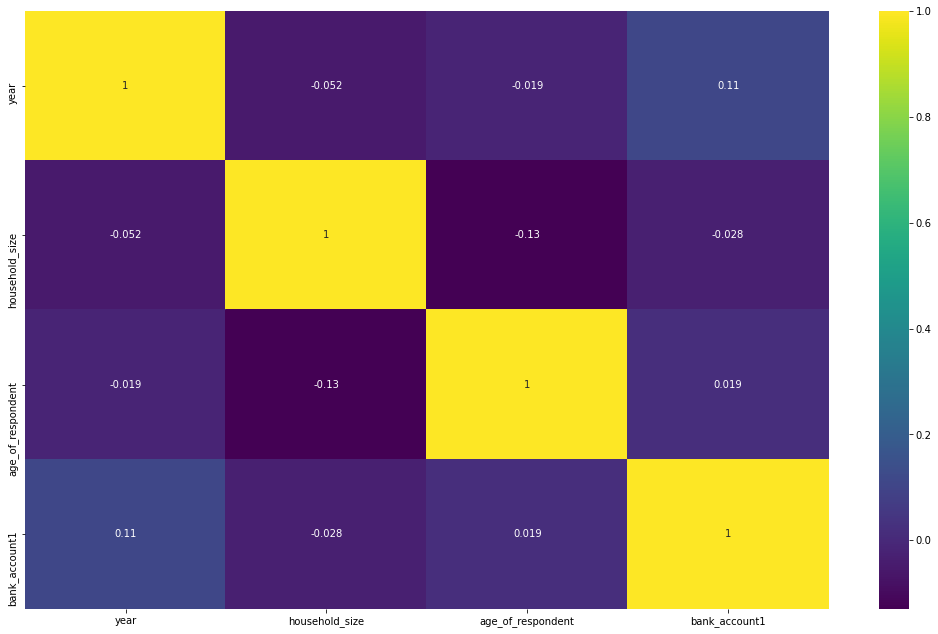

In [111]:
# heatmap showing correlation between the features

plt.figure(figsize=(18,11))

sns.heatmap(train.corr(),annot=True,cmap='viridis');

## PREPROCESSING AND ENCODING 

In [112]:
test_id = test['uniqueid']

In [113]:
test_count = test['']

In [114]:
test

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent
...,...,...,...,...,...,...,...,...,...,...,...,...
10081,Uganda,2018,uniqueid_2998,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
10082,Uganda,2018,uniqueid_2999,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
10083,Uganda,2018,uniqueid_3000,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
10084,Uganda,2018,uniqueid_3001,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed


In [115]:
# droping columns

train.drop(['uniqueid','bank_account','year'], axis=1, inplace=True)
test.drop(['uniqueid','year'], axis=1, inplace=True)

In [116]:
# ordinal encoding for WFH Setup Available
train['cellphone_access'] = train['cellphone_access'].map({'Yes':1, 'No':0})
test['cellphone_access'] = test['cellphone_access'].map({'Yes':1, 'No':0})


In [117]:
# using one hot encoding for no meaningful Ranking


cols = ['country','location_type','gender_of_respondent',
        'relationship_with_head','marital_status','education_level','job_type']

train = pd.get_dummies(train, columns=cols, drop_first=True)
test = pd.get_dummies(test, columns=cols, drop_first=True)

In [118]:
train

,cellphone_access,household_size,age_of_respondent,bank_account1,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,gender_of_respondent_Male,relationship_with_head_Head of Household,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1,3,24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,5,70,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,5,26,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,5,34,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,8,26,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,1,4,48,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23520,1,2,27,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23521,1,5,27,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23522,1,7,30,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [119]:
train.shape

(23524, 32)

In [120]:
test.shape

(10086, 31)

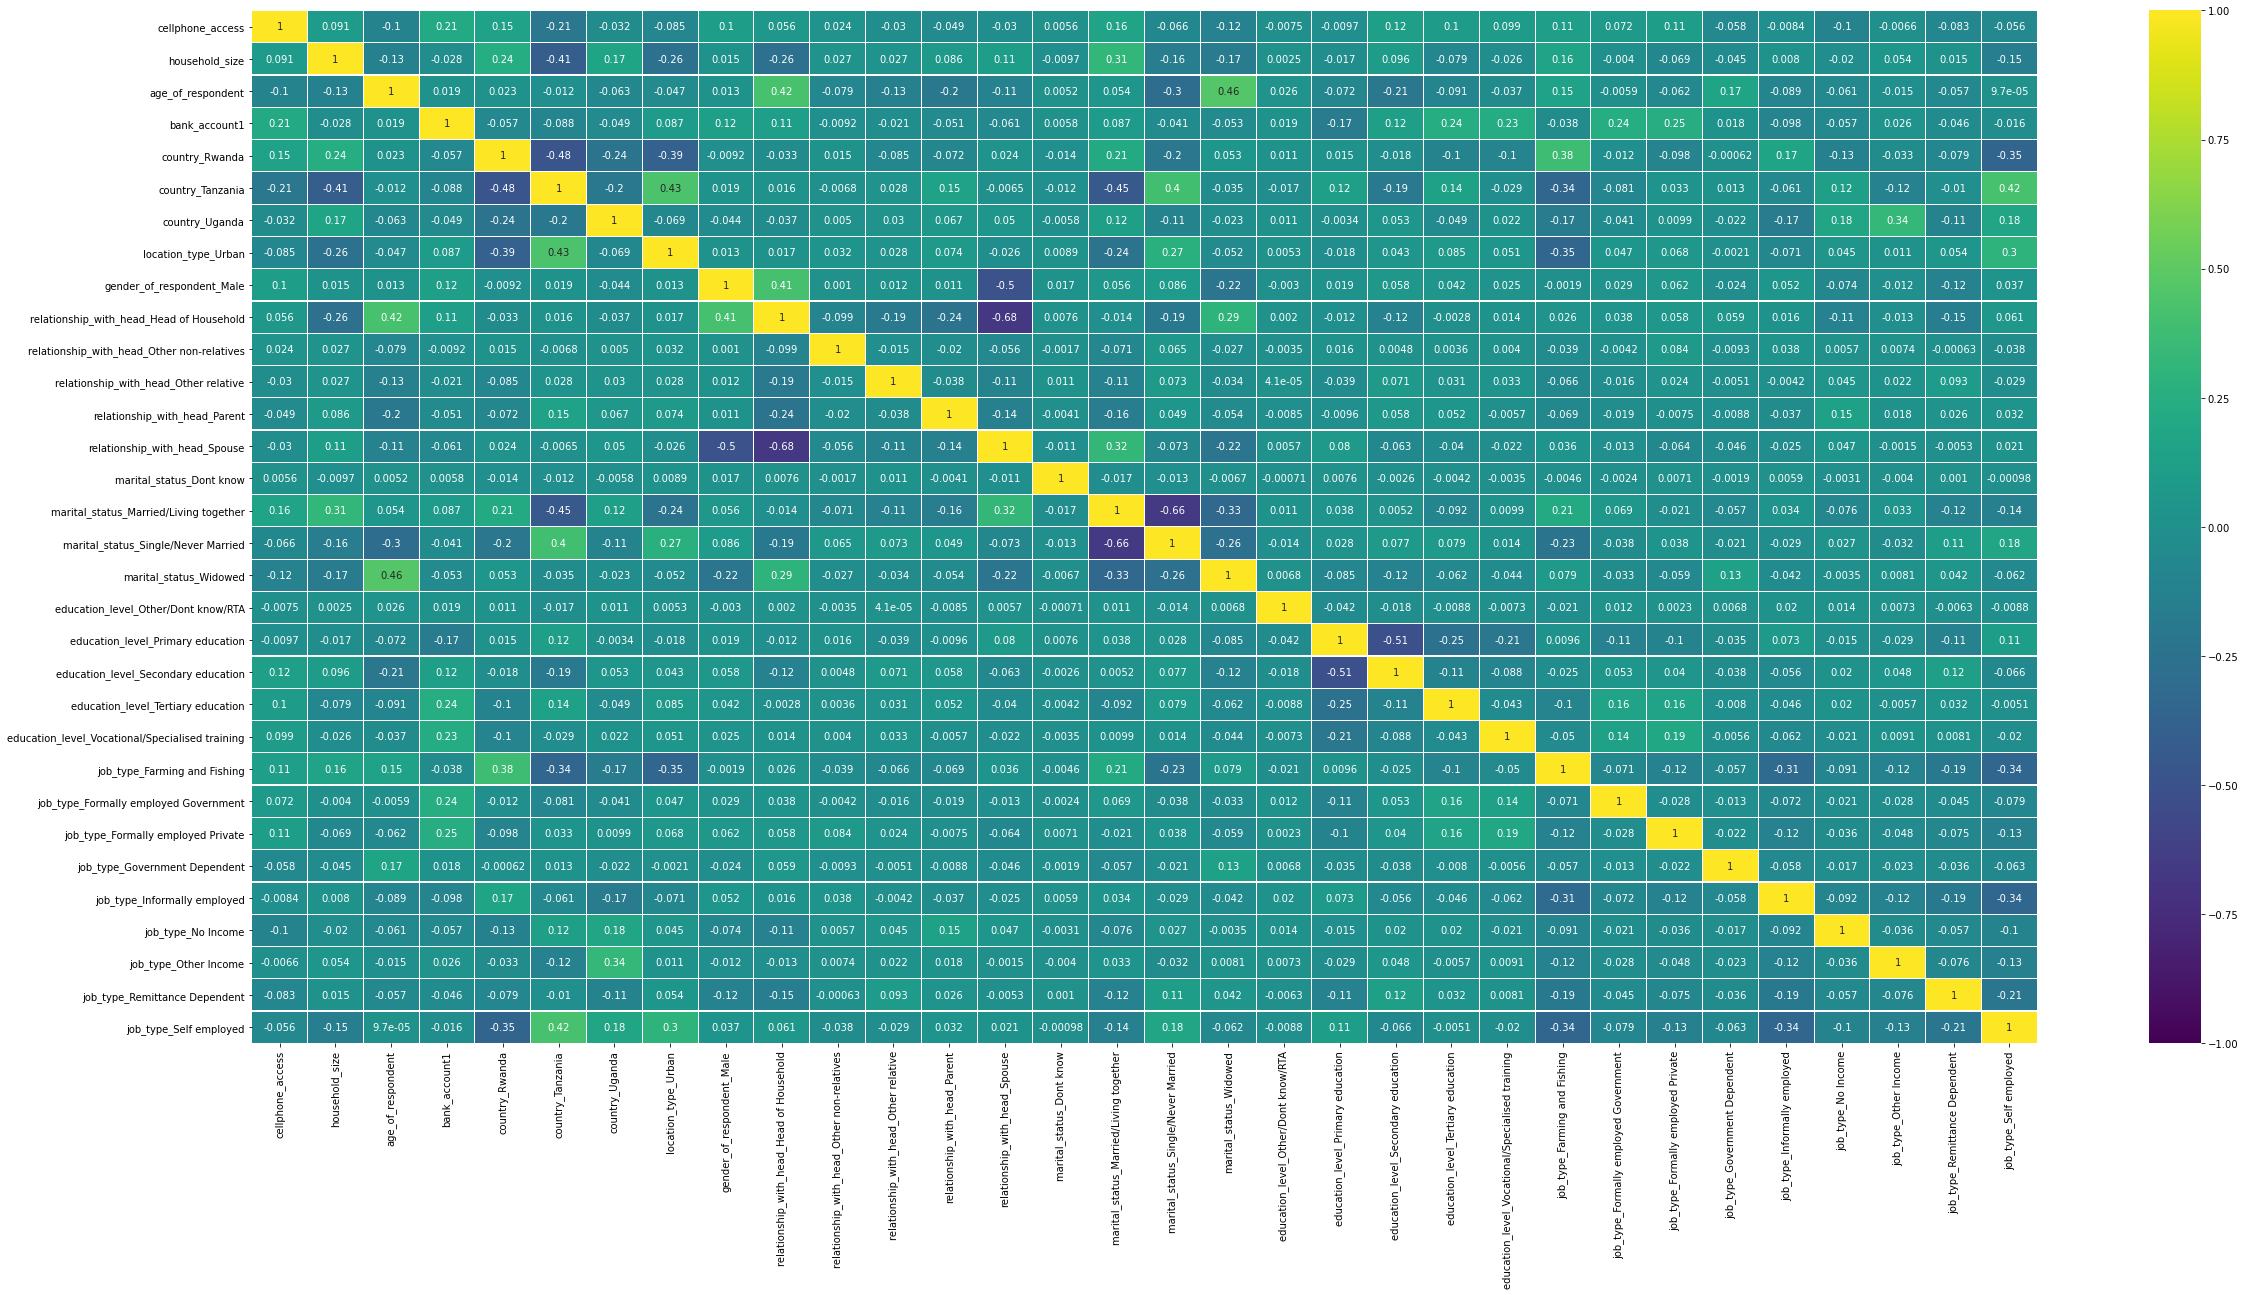

In [121]:
# # correlation heatmap after converting the categorical variables using label encoding to binary numbers

cor = train.corr()
fig = plt.figure(figsize=(40,19))
ax = sns.heatmap(cor, xticklabels=cor.columns,
                 yticklabels=cor.columns, annot=True, linewidths=.2, cmap='viridis', vmin=-1, vmax=1)

### MODELLING

In [122]:
X = train.drop('bank_account1', axis=1)
y = train['bank_account1']

In [123]:
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from sklearn.model_selection import GroupKFold, RepeatedKFold
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=10, shuffle=True, random_state=1)#0#1
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='R2',subsample=0.7,bagging_temperature=0.9, l2_leaf_reg=2, n_estimators=1500, learning_rate=0.025)
    
    #CatBoostRegressor(eval_metric='R2',subsample=0.7, l2_leaf_reg=2)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict(X_test)
    print("err: ",r2_score(y_test,preds))
    errcb.append(r2_score(y_test,preds))
    p = m.predict(test)
    y_pred_totcb.append(p)

0:	learn: 0.0100685	test: 0.0100685	test1: 0.0083461	best: 0.0083461 (0)	total: 14.8ms	remaining: 22.2s
100:	learn: 0.2914883	test: 0.2914883	test1: 0.2467257	best: 0.2467257 (100)	total: 980ms	remaining: 13.6s
200:	learn: 0.3202416	test: 0.3202416	test1: 0.2673818	best: 0.2673818 (200)	total: 1.87s	remaining: 12.1s
300:	learn: 0.3311332	test: 0.3311332	test1: 0.2720300	best: 0.2720300 (300)	total: 2.75s	remaining: 10.9s
400:	learn: 0.3406637	test: 0.3406637	test1: 0.2746825	best: 0.2747194 (399)	total: 3.65s	remaining: 10s
500:	learn: 0.3477965	test: 0.3477965	test1: 0.2759697	best: 0.2759697 (500)	total: 4.59s	remaining: 9.15s
600:	learn: 0.3550770	test: 0.3550770	test1: 0.2773451	best: 0.2773451 (600)	total: 5.62s	remaining: 8.41s
700:	learn: 0.3616700	test: 0.3616700	test1: 0.2773803	best: 0.2776670 (622)	total: 6.51s	remaining: 7.42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2776669528
bestIteration = 622

Shrink model to first 623 iterations.
err:  0.27

200:	learn: 0.3107900	test: 0.3107900	test1: 0.3379367	best: 0.3379367 (200)	total: 2.42s	remaining: 15.7s
300:	learn: 0.3225293	test: 0.3225293	test1: 0.3459154	best: 0.3459154 (300)	total: 3.37s	remaining: 13.4s
400:	learn: 0.3312342	test: 0.3312342	test1: 0.3498663	best: 0.3498663 (400)	total: 4.27s	remaining: 11.7s
500:	learn: 0.3394212	test: 0.3394212	test1: 0.3527458	best: 0.3527884 (497)	total: 5.15s	remaining: 10.3s
600:	learn: 0.3460052	test: 0.3460052	test1: 0.3538381	best: 0.3538660 (599)	total: 6.06s	remaining: 9.06s
700:	learn: 0.3522856	test: 0.3522856	test1: 0.3545013	best: 0.3545509 (692)	total: 7.08s	remaining: 8.07s
800:	learn: 0.3588232	test: 0.3588232	test1: 0.3548023	best: 0.3548360 (718)	total: 8.02s	remaining: 7s
900:	learn: 0.3645617	test: 0.3645617	test1: 0.3547479	best: 0.3551676 (863)	total: 8.96s	remaining: 5.95s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.355167599
bestIteration = 863

Shrink model to first 864 iterations.
err:  0.3

In [124]:
np.mean(errcb)

0.30902228338957016

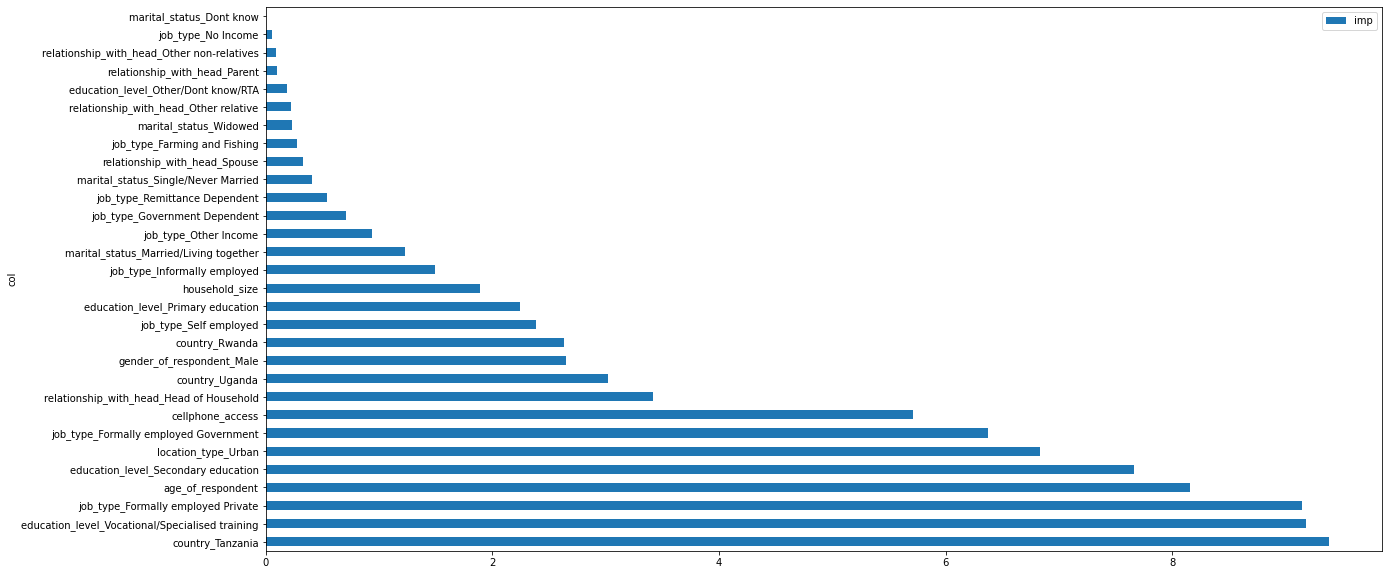

In [125]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')

In [126]:
d = {"uniqueid": test_id, 'bank_account1': abs((np.mean(y_pred_totcb, 0)))}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["uniqueid", 'bank_account1']]

In [127]:
test_predictions.head()

,uniqueid,bank_account1
0,uniqueid_6056,0.852669
1,uniqueid_6060,0.846850
2,uniqueid_6065,0.052241
3,uniqueid_6072,0.012622
4,uniqueid_6073,0.052100


In [128]:
test_predictions.to_csv('cat1.csv', index=False)

# Xgboost Model

In [129]:
from xgboost import XGBRegressor

In [130]:
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from sklearn.model_selection import GroupKFold, RepeatedKFold
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=10, shuffle=True, random_state=10)#25
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m =XGBRegressor(learning_rate=0.1, n_estimator=1500)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict(X_test)
    print("err: ",r2_score(y_test,preds))
    errcb.append(r2_score(y_test,preds))
    p = m.predict(test)
    y_pred_totcb.append(p)

[12:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.46881	validation_1-rmse:0.46902
[99]	validation_0-rmse:0.26899	validation_1-rmse:0.28560
err:  0.3115417495570003
[12:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.46866	validation_1-rmse:0.46880
[99]	validation_0-rmse:0

In [131]:
np.mean(errcb)

0.3019576266104189

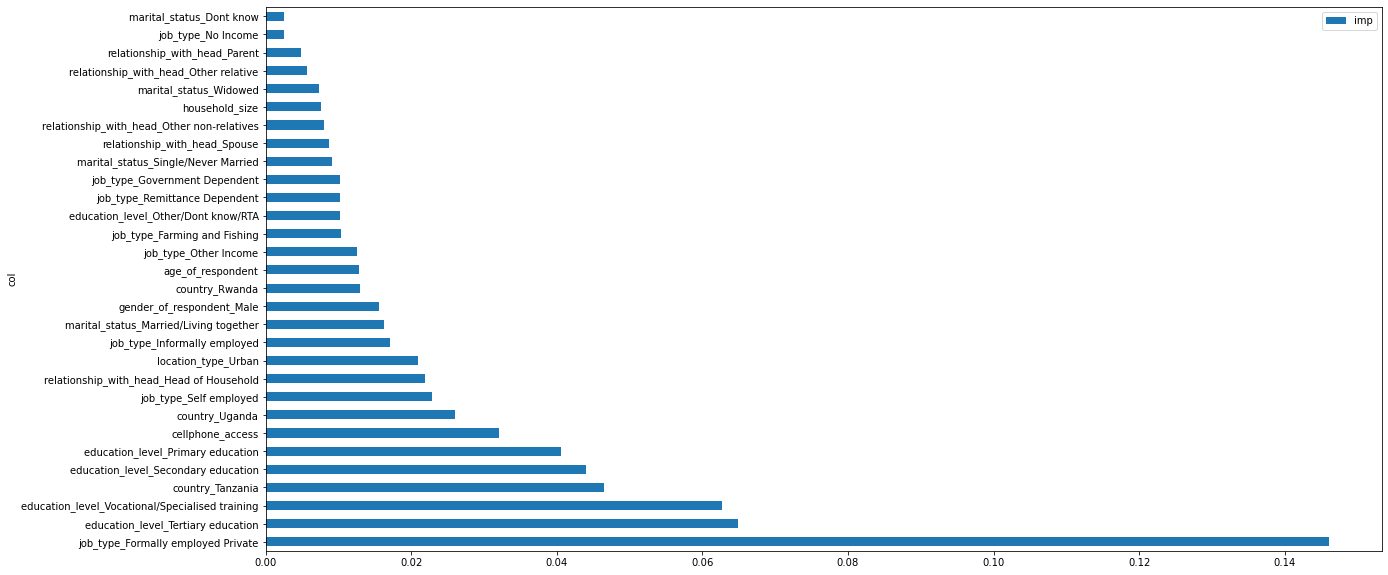

In [132]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [133]:
d = {"uniqueid": test_id, 'bank_account1': abs((np.mean(y_pred_totcb, 0)))}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["uniqueid", 'bank_account1']]

In [134]:
test_predictions.to_csv('xgb1.csv', index=False)

# Ensemble

In [160]:
a = pd.read_csv('cat1.csv')
b = pd.read_csv('xgb1.csv')

In [161]:
a['bank_account1'].corr(b['bank_account1'])

0.9891014607406557

In [162]:
a['bank_account1'] = 0.65 * a['bank_account1'] + 0.35 * b['bank_account1']

In [163]:
a.to_csv('zindi.csv', index=False)

In [164]:
a.head()

,uniqueid,bank_account1
0,uniqueid_6056,0.855959
1,uniqueid_6060,0.829951
2,uniqueid_6065,0.060666
3,uniqueid_6072,0.014873
4,uniqueid_6073,0.047133


In [165]:
np.random.seed(25)

In [166]:
a['bank_account1'] = a['bank_account1'].round(0)

In [167]:
a.head()

,uniqueid,bank_account1
0,uniqueid_6056,1.0
1,uniqueid_6060,1.0
2,uniqueid_6065,0.0
3,uniqueid_6072,0.0
4,uniqueid_6073,0.0


In [168]:
a['bank_account1']= a['bank_account1'].values.astype(int)

In [173]:
bank= a['bank_account1'].values
bank

array([1, 1, 0, ..., 0, 0, 0])

In [174]:
#Create a  DataFrame with the unique ids and our prediction regarding whether the best offer is either 0 or 1 
submission_file = pd.DataFrame({'unique_id':test_id + " x " + test_count,'bank_account':bank})

In [175]:
#Visualize the first 5 rows
submission_file.head()

,unique_id,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [176]:
submission_file.to_csv('Sub_fin_inc.csv')

In [177]:
test.shape

(10086, 31)